Numerical Wave Tank (2D Version)
===========================

This notebook provides a numerical model of a wave tank that would look something like this schematically:

<img src="files/wavetank.png">

- The numerical model is provided by Proteus (http://proteus.usace.army.mil)
- Proteus is being developed at ERDC and includes 2D and 3D versions of this numerical model
- This notebook will stick to 2D because it's faster and easier to pre- and post-process.

In [1]:
%run talktools

Mathematical Model
===============

To model a tank with breaking and overtopping, we solve the following air/water flow equations in 2D (a vertical slice):

$$
\begin{eqnarray}
\nabla \cdot \left( \epsilon \mathbf v \right) &=& s \\
\frac{\partial \left( \epsilon \mathbf v \right)}{\partial t} +\nabla \cdot  \left(\epsilon \mathbf v \otimes \mathbf v\right) -  \nabla \cdot \left\{\epsilon \nu_t \left(\nabla  \mathbf v+\nabla \mathbf v^T\right) \right\} + \mathbf r + \frac{\epsilon \nabla p}{\rho} &=& 0 \\
\frac{\partial \phi}{\partial t} + \mathbf v \cdot \nabla \phi &=& 0 \\
\|\nabla \phi\| &=& 1 \\
\frac{\partial \theta}{\partial t} + \nabla \cdot \left( \theta \epsilon \mathbf v \right) &=& 0 \\
H(\phi) &=& \theta 
\end{eqnarray}
$$

Notes about this demo
================

- This software can be run locally on mac, windows, and linux if the Proteus stack is installed.
- It can also be accessed with a cloud service like Sagemath Cloud, Wakari, or an internal cloud server if we invest in setting one up (you are probably viewing on Sagemath Cloud)
- This particular notebook can also be saved as a Python script and run on HPC machines if they have the Proteus software stack installed
- Grid generation, specification of input parameters like waves, boundary conditions, and material properties can all be viewed, set from pre-existing definitions, or redefined in this notebook.
- The simulation is kicked off in the notebook as a seperate thread and monitored
- The data is archived  in XDMF, which can be opened upon completion of the simulation for post-processing, furthermore additional simulations and multiple scripted runs can be orchestrated by modifying this notebook.



Parallelism 
=========

- We need to use multiple processors to compute the solution efficiently in 3D and sometimes even in 2D. 
- The IPython infrastructure allows us to attach to a set of "engines" (e.g. MPI tasks on an HPC machine) 

In [2]:
from IPython.parallel import Client, error
cluster = Client(profile='mpi')
view = cluster[:]

IPython Parallel "Magics"
====================

As a first example of executing code in parallel on our, we use the cell magic `%%px` to execute some basic MPI code on every engine in our cluster. 


In [3]:
%%px
from mpi4py import MPI
mpi = MPI.COMM_WORLD
bcast = mpi.bcast
barrier = mpi.barrier
rank = mpi.rank
print "MPI rank: %i/%i" % (mpi.rank,mpi.size)

[stdout:0] MPI rank: 2/4
[stdout:1] MPI rank: 1/4
[stdout:2] MPI rank: 3/4
[stdout:3] MPI rank: 0/4


Load Proteus
==========

Proteus is a Python package consiting of multiple modules. We are going to define a problem and run a simulation interactively, so we pull in the iproteus (interactive proteus) module to set up a basic environment.

Notes:
---------

- Proteus runs with logging that records verying amounts of information by setting logLevel from 1 to 11
- The log is stored  in a .log file, which can be downloaded
- If Profiling.verbose is set  to True then logging will show up in certain output cells of the notebook, which is usually not what you want

In [5]:
%%px
import sys
import proteus
# Required imports
from proteus.iproteus import * 
from proteus import default_n, default_s, default_so
Profiling.logLevel=5
Profiling.verbose=False

Define the tank geometry
===================

Importing the tank module reads a text file for the bathymetry transect and generates a polygonal domain. There are several options for how we can modify it:

- add a file upload box to just upload a different bottom bathymetry
- manipulate an interactive version of the resulting domain (an interactive version of the plot below)
- manipulate vertices directly in domain.vertices and domain.segments



In [7]:
!echo "40" > refinement_level.txt
#!tar czvf mydir.tar.gz  ls_p.py tank_so.py twp_navier_stokes_n.py redist_n.py   twp_navier_stokes_p.py redist_p.py vof_n.py vof_p.py ls_consrv_n.py ls_consrv_p.py ls_n.py tank.py
#!scp mydir.tar.gz spirit01.afrl.hpc.mil:

In [8]:
#%%px 
#import subprocess
#if rank == 0:
  #  status_gz = subprocess.call("gunzip " +  "mydir.tar.gz", shell=True)
    #status_tar = subprocess.call("tar "+"xvf mydir.tar",shell=True)
#    os.system('tar xzvf mydir.tgz')

In [9]:
%%px
import tank,tank_so

In [10]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


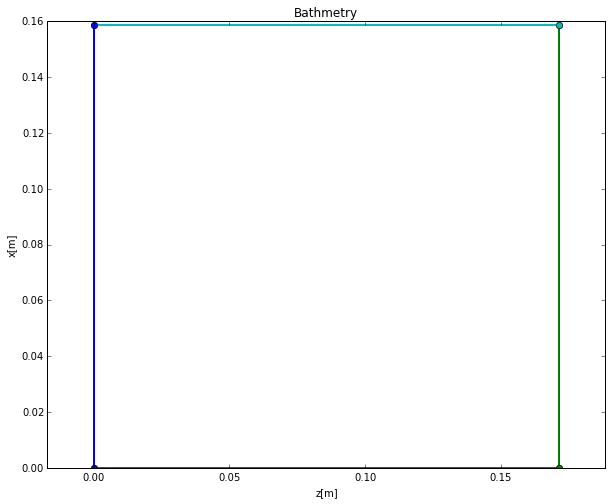

In [11]:
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
plt.title('Bathmetry')
plt.xlabel(r'z[m]')
plt.ylabel(r'x[m]')
colors = ['b','g','r','c','m','y','k','w']
domain = view['tank.domain'][0]
segments = view['tank.segments'][0]
pylab.xlim(domain.x[0]-0.1*domain.L[0],domain.x[0]+domain.L[0]+0.1*domain.L[0])
for si,s in enumerate(segments):
    plot([domain.vertices[s[0]][0],
          domain.vertices[s[1]][0]],
         [domain.vertices[s[0]][1],domain.vertices[s[1]][1]],
         color=colors[domain.segmentFlags[si]-1],
         linewidth=2,
         marker='o')

Wave Input
=========

Plot same predefined wave functions first

Define new wave functions
====================

If you want to use something not previously written, you can just redefine them. Note you can also change any of the wave parameters

Time Stepping
===========
Tell proteus how long to run, when to archive the solution, etc.

Physics and Numerics
=================

Load the modules the define the equations to be solved and the numerical methods to use.

In [12]:
%%px
from proteus import Comm
from petsc4py import PETSc

so = tank_so
so.tnList = so.tnList
pList=[]
nList=[]
so.sList=[]
OptDB = PETSc.Options()
for (p,n) in so.pnList:
    so.sList.append(default_s)
    pList.append(__import__(p))
    nList.append(__import__(n))
    pList[-1].name = p
    nList[-1].multilevelLinearSolver = default_n.KSP_petsc4py
    nList[-1].levelLinearSolver = default_n.KSP_petsc4py
    OptDB.setValue(nList[-1].linear_solver_options_prefix+"ksp_type", "preonly")
    OptDB.setValue(nList[-1].linear_solver_options_prefix+"pc_type", "lu")
    OptDB.setValue(nList[-1].linear_solver_options_prefix+"pc_factor_mat_solver_package","superlu_dist")
opts.save_dof = True
opts.dataDir='.'
opts.probDir='.'
opts.logLevel=7
opts.verbose=True

Numerical Solution Object
====================

No we create an the numerical wavetank object and set it up to run in a thread on each engine.

In [13]:
%%px
ns = NumericalSolution.NS_base(so, pList, nList, so.sList, opts)

[stdout:0] 
TriangleBaseMesh nbase=1 baseFlags= VApq30Dena0.00000828 
pressure [4101 4104 4107 4110 4113 4116 4119 4122 4125 4128 4131 4134 4137 4140 4143
 4146 4149 4152 4155 4158 4161 4164 4167 4170 4173 4176 4179 4182 4185 4188
 4191 4194 4197 4200 4203 4206 4209 4212 4215 4218 4221 4224 4227 4230 4233
 4236 4239 4242 4245 4248 4251 4254 4257 4260 4263 4266 4269 4272 4275 4278
 4281 4284 4287 4290 4293 4296 4299 4302 4305 4308 4311 4314 4317 4320 4323
 4326 4329 4332 4335 4338 4341 4344 4347 4350 4353 4356 4359 4362 4365 4368
 4371 4374 4377 4380 4383 4386 4389 4392 4395 4398 4401 4404 4407 4410 4413
 4416 4419 4422 4425 4428 4431 4434 4437 4440 4443 4446 4449 4452 4455 4458
 4461 4464 4467 4470 4473 4476 4479 4482 4485 4488 4491 4494 4497 4500 4503
 4506 4509 4512 4515 4518 4521 4524 4527 4530 4533 4536 4539 4542 4545 4548
 4551 4554 4557 4560 4563 4566 4569 4572 4575 4578 4581 4584 4587 4590 4593
 4596 4599 4602 4605 4608 4611 4614 4617 4620 4623 4626 4629 4632 4635 4638
 4641 464

In [14]:
%%px --noblock
from threading import Thread
# Create a thread wrapper for the simulation.  The target must be an argument-less
# function so we wrap the call to `calculateSolution` in a simple lambda:
simulation_thread = Thread(target = lambda : ns.calculateSolution('run1'))

<AsyncResult: execute>

Define some functions to help monitor the calculation
------------------------------------------------

In [15]:
from IPython.core.display import clear_output

def plot_current_results(in_place=True):
    """Makes a blocking call to retrieve remote data and displays the solution mesh
    as a contour plot.
    
    Parameters
    ----------
    in_place : bool
        By default it calls clear_output so that new plots replace old ones.  Set
        to False to allow keeping of all previous outputs.
    """
    global nn,x,y,u,triangles
    # We make a blocking call to load the remote data from the simulation into simple named 
    # variables we can read from the engine namespaces
    #load_simulation_globals()
    view.apply_sync(load_simulation_globals)
    # And now we can use the view to read these variables from all the engines.  Then we
    # concatenate all of them into single arrays for local plotting
    x = np.concatenate(view['x'])
    y = np.concatenate(view['y'])
    u = np.concatenate(view['u'])
    shifts = numpy.cumsum([0]+view['nn'][:-1])
    flat_triangles = np.concatenate([ tri + shift for tri,shift in zip(view['triangles'], shifts) ])
    #flat_triangles=triangles
    # We can now call the matplotlib plotting function we need
    fig, ax = plt.subplots(subplot_kw=dict(aspect='equal'))
    ax.tricontourf(x, y, flat_triangles, u)
    #from matplotlib import tri
    #mesh = tri.Triangulation(x,y,flat_triangles)
    #help(mesh)
    #ip = tri.LinearTriInterpolator(triangulation, u, trifinder=None)
    #X = np.linspace(0,tank.domain.L[0],40)
    #Z = np.linspace(0,tank.domain.L[1],40)
    #U = np.zeros((40,40),'d')
    #W = np.zeros((40,40),'d')
    #U = ip(X,Z)
    # We clear the notebook output before plotting this if in-place plot updating is requested
    if in_place:
        clear_output()
    display(fig)
    return fig

In [16]:
def load_simulation_globals():
    """Put some variables we need in engine namespace.

    These can then be retrieved by clients for inspection, visualization, etc.
    """
    global nn, x, y, u, triangles
    model = ns.modelList[1].levelModelList[-1]
    nodes = model.mesh.nodeArray
    triangles = model.mesh.elementNodesArray
    x = nodes[:,0]
    y = nodes[:,1]
    u = model.u[0].dof_last
    nn = len(x)

In [17]:
def simulation_alive():
    """Return True if the simulation thread is still running on any engine.
    """
    #return simulation_thread.is_alive()
    return any(view.apply_sync(lambda : simulation_thread.is_alive()))

In [18]:
def monitor_simulation(refresh=5.0, plots_in_place=True):
    """Monitor the simulation progress and call plotting routine.

    Supress KeyboardInterrupt exception if interrupted, ensure that the last 
    figure is always displayed and provide basic timing and simulation status.

    Parameters
    ----------
    refresh : float
      Refresh interval between calls to retrieve and plot data.  The default
      is 5s, adjust depending on the desired refresh rate, but be aware that 
      very short intervals will start having a significant impact.

    plots_in_place : bool
       If true, every new figure replaces the last one, producing a (slow)
       animation effect in the notebook.  If false, all frames are plotted
       in sequence and appended in the output area.
    """
    import datetime as dt, time
    
    if not simulation_alive():
        plot_current_results(in_place=plots_in_place)
        plt.close('all')
        print 'Simulation has already finished, no monitoring to do.'
        return
    
    t0 = dt.datetime.now()
    fig = None
    try:
        while simulation_alive():
            fig = plot_current_results(in_place=plots_in_place)
            plt.close('all') # prevent re-plot of old figures
            time.sleep(refresh) # so we don't hammer the server too fast
    except (KeyboardInterrupt):#, error.TimeoutError):
        msg = 'Monitoring interrupted, simulation is ongoing!'
    else:
        msg = 'Simulation completed!'
    tmon = dt.datetime.now() - t0
    if plots_in_place and fig is not None:
        clear_output()
        display(fig)
    print msg
    print 'Monitored for: %s.' % tmon

Run the tank
==========

In [19]:
%px simulation_thread.start()

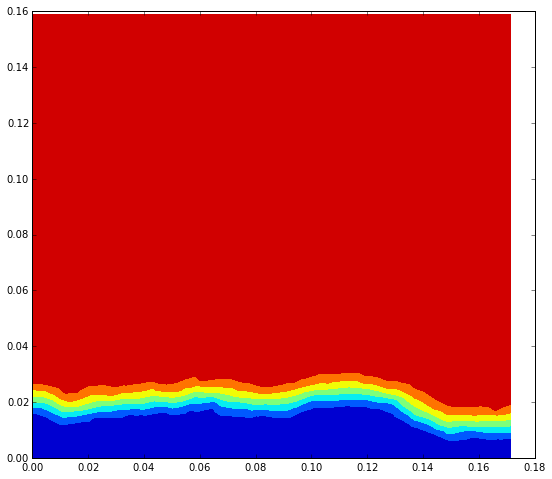

Simulation completed!
Monitored for: 0:16:28.029389.


In [20]:
monitor_simulation(refresh=5.0)

Post-process the numerical solution
==========================

In [21]:
%%px
from tables import  openFile
archive = openFile('tank_p%d.h5' % (rank,),'r')

In [22]:
def load_post_simulation_globals(it):
    """Put some variables we need in engine namespace.

    These can then be retrieved by clients for inspection, visualization, etc.
    """
    global phi
    print it
    phi=archive.getNode("/phi"+`it`)[:];

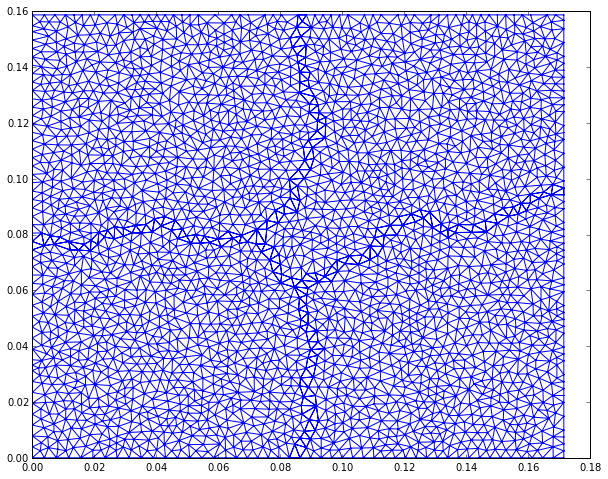

In [23]:
x = np.concatenate(view['x'])
y = np.concatenate(view['y'])
shifts = numpy.cumsum([0]+view['nn'][:-1])
flat_triangles = np.concatenate([ tri + shift for tri,shift in zip(view['triangles'], shifts) ])
triplot(x,y,flat_triangles)

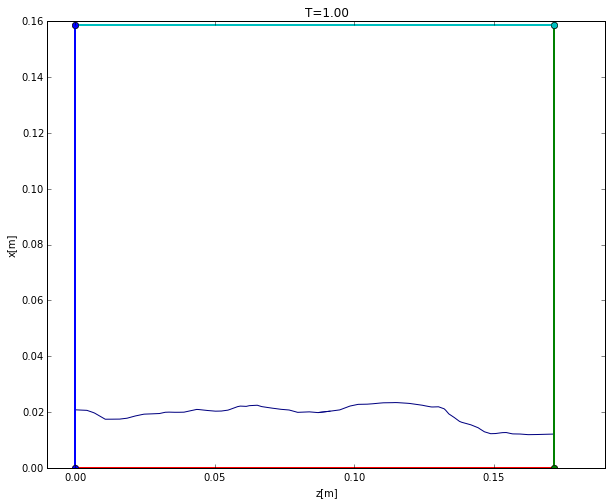

In [24]:
!rm phi*png
import tank
for it,t in enumerate(view['tank_so.tnList'][0]):
    view.apply_sync(load_post_simulation_globals,it)
    phi = np.concatenate(view['phi'])
    pyplot.clf()
    plt.xlabel(r'z[m]')
    plt.ylabel(r'x[m]')
    colors = ['b','g','r','c','m','y','k','w']
    pylab.xlim(tank.domain.x[0]-0.1*tank.domain.L[0],tank.domain.x[0]+tank.domain.L[0]+0.1*tank.domain.L[0])    
    pyplot.axis('equal')
    for si,s in enumerate(tank.segments):
        pyplot.plot([tank.domain.vertices[s[0]][0],
                     tank.domain.vertices[s[1]][0]],
                    [tank.domain.vertices[s[0]][1],
                     tank.domain.vertices[s[1]][1]],
                    color=colors[tank.domain.segmentFlags[si]-1],
                    linewidth=2,
                    marker='o')
    pyplot.tricontour(x,y,flat_triangles,phi,[0])
    pyplot.title('T=%2.2f' % (t,))
    pyplot.savefig('phi%4.4d.png' % (it,))

In [25]:
!avconv -y -i phi%4d.png -c libx264 -qscale 1 tankPhi.mp4

avconv version 9.18-6:9.18-0ubuntu0.14.04.1, Copyright (c) 2000-2014 the Libav developers
  built on Mar 16 2015 13:19:10 with gcc 4.8 (Ubuntu 4.8.2-19ubuntu1)
Input #0, image2, from 'phi%4d.png':
  Duration: 00:00:04.08, start: 0.000000, bitrate: N/A
    Stream #0.0: Video: png, bgra, 720x576, 25 fps, 25 tbr, 25 tbn
[libx264 @ 0x71cd60] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX
[libx264 @ 0x71cd60] profile High, level 3.0
[libx264 @ 0x71cd60] 264 - core 142 r2389 956c8d8 - H.264/MPEG-4 AVC codec - Copyleft 2003-2014 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=6 lookahead_threads=1 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenec

In [26]:
from IPython.core.display import HTML
data_uri_mp4 = open("tankPhi.mp4", "rb").read().encode("base64").replace("\n", "")
video_tag = """<video controls>
<source type ="video/mp4" src="data:video/mp4;base64,{mp4}"/>
Your browser does not support the video tag
</video>""".format(mp4=data_uri_mp4)
HTML(data=video_tag)

In [27]:
from IPython.display import FileLink,FileLinks
FileLink('tankPhi.mp4')

/home/cekees/proteus-notebooks/tankPhi.mp4